In [1]:
import os
import time
import sys
from pathlib import Path
import torch
import numpy as np
import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD, Array1f as Vector1fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C
from image_util import *
import matplotlib.pyplot as plt
from PIL import Image
from embedder import *
from torch import nn
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

torch.manual_seed(0)

In [2]:
encoder, embed_dim = get_hashgrid_embedder(2)
# fembed, embed_dim = get_position_embedder(2)

# fembed, embed_dim = get_embedder(10, 2)

print("embed_dim", embed_dim)
layer_size = 64
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(embed_dim, layer_size),
          nn.ReLU(inplace=True),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(inplace=True),
          nn.Linear(layer_size, 3),
          nn.Sigmoid()
        ).cuda()
    def forward(self, x):
        return self.layers(x)

embed_dim 32


In [3]:
mlp_image = MLP()
x = np.linspace(0, 1, 512)
y = np.linspace(0, 1, 512)
debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()
debug_color = (torch.transpose(debug_color.reshape(2, -1), 0, 1))

target_img = cv2.imread("./data/texture/illya.exr", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
target_img = cv2.cvtColor(target_img, cv2.COLOR_RGB2BGR)
target_img = torch.tensor(target_img, device='cuda', dtype=torch.float32)

<ipython-input-3-cd9a160a9e8d>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()


it: 0 loss 0.23238074779510498


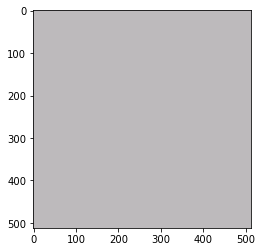

In [4]:
def eval_target(target_img, uv):
    with torch.no_grad():
        ind = torch.floor(uv*512).to(torch.long)
        idx = ind[:,1]*512 + ind[:,0]
        target_img = target_img.reshape(-1, 3)
        return target_img.reshape(-1, 3)[idx]

rnd_in = torch.rand([65536, 2], device='cuda', dtype=torch.float32)

opt_para = params = list(encoder.parameters()) + list(mlp_image.parameters())

# train a network
optimizer = torch.optim.Adam(opt_para, lr=1e-3,       
                             weight_decay = 1e-8,
                              eps = 1e-8,
                              betas = (0.9, 0.99),
                        )
num_iter = 1
for it in range(num_iter+1):
    optimizer.zero_grad()
    rnd_in = torch.rand([65536, 2], device='cuda', dtype=torch.float32)
    
    
    rnd_embed = encoder.forward(rnd_in)
    opt_map = mlp_image(rnd_embed)
    tar_map = eval_target(target_img, rnd_in)
    loss = (tar_map-opt_map).abs().mean()
#     loss = (((tar_map-opt_map)**2.0) / (opt_map.detach()**2.0 + 0.01)).mean()
    loss.backward()
    optimizer.step()

    if (it % 10 == 0 and it < 100) or it % 100 == 0:
        print("it:", it, "loss", loss.item())
        data_in = encoder.forward(debug_color)
        opt_map = mlp_image(data_in)
        img = to_srgb(opt_map.detach().cpu().numpy().reshape((512, 512, 3)))
        imgplot = plt.imshow(img)
        plt.show()

In [5]:
class SimpleIntegrator():
    def __init__(self, spp, width, height, encoder, mlp_image):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sampler = psdr.Sampler()
        self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))
        self.mlp_data = mlp_image
        self.encoder = encoder
        self.dummy = None
        
        
    @drjit.wrap_ad(source='drjit', target='torch')
    def eval_mlp(self, uv, dummy):
        with torch.enable_grad():
            torch_rnd_embed = self.encoder.forward(uv)
            torch_image = self.mlp_data.forward(torch_rnd_embed) + dummy
            return torch_image

    def render(self):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height)
            samples = drjit.cuda.ad.TensorXf(drjit.ravel(samples), shape=[drjit.width(samples), 2])
        with drjit.resume_grad():
            value = self.eval_mlp(samples, self.dummy)
            value = drjit.unravel(Vector3fD, value)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

In [6]:
class RenderFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, integrator, dummy):
        with drjit.suspend_grad():
            integrator.dummy = drjit.cuda.ad.TensorXf(dummy.unsqueeze(0))
            psdr_image = integrator.render()
            image = psdr_image.torch()
            ctx.integrator = integrator
            return image.reshape((512, 512, 3))

    @staticmethod
    def backward(ctx, grad_out):
        with drjit.resume_grad():
            with torch.enable_grad():
                drjit.enable_grad(ctx.integrator.dummy) 
                image_grad = Vector3fC(grad_out.reshape(-1,3))
                image = ctx.integrator.render()
                tmp = drjit.dot(image_grad, image)
                drjit.backward(tmp)            
                grad_drjit = []
                grad_drjit_mlp_para = drjit.grad(ctx.integrator.dummy).torch()
                grad_drjit.append(grad_drjit_mlp_para)        
                return tuple([None] + grad_drjit)

class Renderer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, integrator, dummy):
        image = RenderFunction.apply(integrator, dummy)
        return image
psdr_render = Renderer()


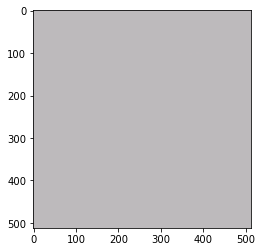

In [7]:
spp = 1
height = 512
width = 512
integrator = SimpleIntegrator(spp, height, width, encoder, mlp_image)
dummy = torch.tensor([0.0], device='cuda', dtype=torch.float32)
opt_map = psdr_render.forward(integrator, dummy)
img = to_srgb(opt_map.detach().cpu().numpy().reshape((512, 512, 3)))
imgplot = plt.imshow(img)
plt.show()


it: 0 loss 0.23076701164245605


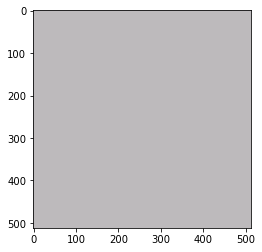

it: 10 loss 0.22813193500041962


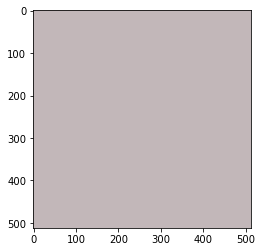

it: 20 loss 0.2258651852607727


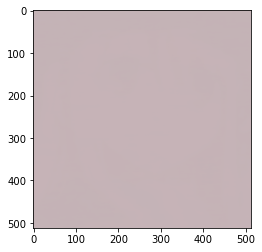

it: 30 loss 0.22058159112930298


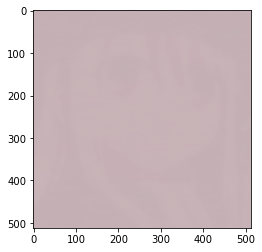

it: 40 loss 0.20608004927635193


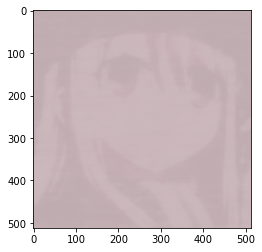

it: 50 loss 0.17572352290153503


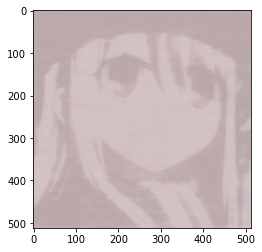

it: 60 loss 0.12950287759304047


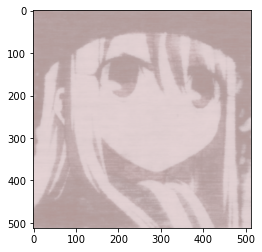

it: 70 loss 0.09758701920509338


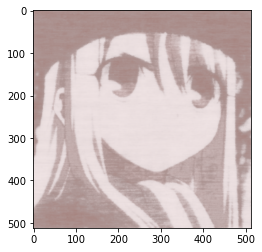

it: 80 loss 0.07487495243549347


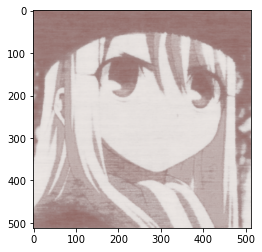

it: 90 loss 0.053782038390636444


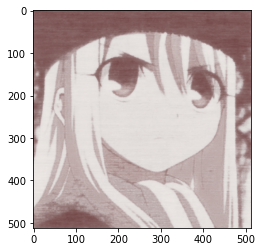

it: 100 loss 0.03930286318063736


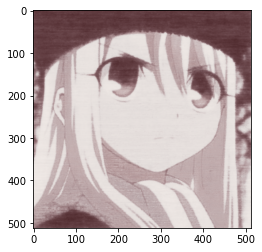

it: 150 loss 0.023091424256563187


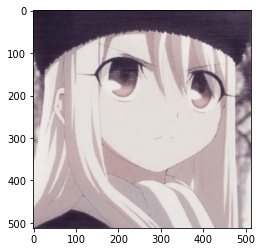

it: 200 loss 0.015442724339663982


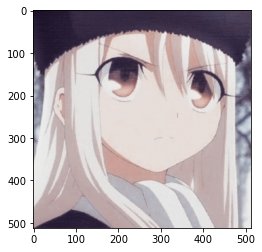

it: 250 loss 0.013312369585037231


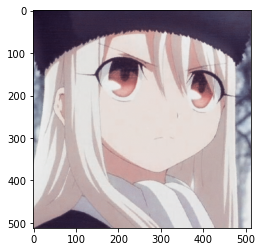

it: 300 loss 0.01202507596462965


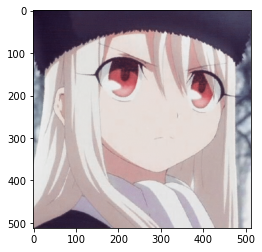

In [8]:
opt_para = list(integrator.encoder.parameters()) + list(integrator.mlp_data.parameters())
optimizer = torch.optim.Adam(opt_para, lr=1e-3)
num_iter = 300
for it in range(num_iter+1):
    optimizer.zero_grad()
    dummy = torch.tensor([0.0], device='cuda', dtype=torch.float32, requires_grad=True)
    opt_map = psdr_render.forward(integrator, dummy)
    tar_map = target_img
    loss = (tar_map-opt_map).abs().mean()
    
    loss.backward()
    optimizer.step()

    if (it % 10 == 0 and it < 100) or it % 50 == 0:
        print("it:", it, "loss", loss.item())
        img = to_srgb(opt_map.detach().cpu().numpy().reshape((512, 512, 3)))
        imgplot = plt.imshow(img)
        plt.show()
